In [1]:
cd ../..

C:\Users\user\Documents\dton-wildfires-cleaner


#### What should drought processing do?

Given droughts are not localised events, what should this processing even do? In my opinion, the main purpose should be to provide a great visualization of the drought.

Ideas:
1. Determine if you can detect drought at all (did NDVI really drop etc)
2. Perhaps narrow the location down to a where the change in drought indices is the most apparent
3. Find a non-drought-affected comparable image from the same period in previous years

let's try the most straight-forward and obvious approach:

Process:
1. Fetch NDVI values for the full available timespan
2. Determine "monthly" averages by averaging out the data up to 1 year before the event
3. Get most recent period of below average values
4. Find an equivalent period with an (above average) NDVI
5. Find the least cloud affected dates in both periods
6. Zoom in on a cloudless area where the difference in NDVI is greatest

In [2]:
from pprint import pprint
from datetime import timedelta, datetime

from sentinelhub import SHConfig, FisRequest, DataCollection, CustomUrlParam
from sentinelhub.time_utils import iso_to_datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from queries import droughts_query
from processing.bbox_utils import create_bbox
from processing.fetching_utils import get_image
from processing.date_utils import start_of_day, end_of_day

from utils import get_env_var, print_titles
from events_utils import filter_events_by_concept_thresholds
from event_registry_utils import EventRegistry

In [3]:
INSTANCE_ID_DROUGHTS = get_env_var("INSTANCE_ID_DROUGHTS")
EVENT_REGISTRY_API_KEY = get_env_var("EVENT_REGISTRY_API_KEY")
CLIENT_ID = get_env_var("CLIENT_ID")
CLIENT_SECRET = get_env_var("CLIENT_SECRET")

config = SHConfig()
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET
config.instance_id = INSTANCE_ID_DROUGHTS

date_start = "2020-01-01"
date_end = "2021-01-01"

event_registry = EventRegistry(EVENT_REGISTRY_API_KEY)

#### 2020 events for testing

```
eng-6410638: US: More must be done to protect Colorado River from drought
eng-6324352: Climate change and 'atmospheric thirst' to increase fire danger and drought in NV and CA
eng-6253418: 'Potholes' from the past help drought-hit Zimbabwean farmers save water
eng-6239690: South America ravaged by unprecedented drought and fires - France 24
eng-6228116: Connecticut Approved for Federal Disaster Designation Due to Drought
eng-6227334: Dust Bowl 2.0? Rising Great Plains dust levels stir concerns
eng-6193114: Colorado's dry conditions worsen, with nearly 60% of state in extreme drought
eng-6190738: In Pictures: Navajo Nation's water-scarce life
eng-6174006: Thursday marked the start of a new water year for New Mexico, but water managers are u ...
eng-6177941: Federal Government agrees to boost vital drought measure
eng-6167743: Tax relief aimed at New Mexico's drought-stricken ranchers
eng-6175380: Bad apples: Extreme weather and COVID blight Kashmir's crops
eng-6152759: Small Forest Fires Cropping Up In N.H. As Severe Drought Continues
eng-6150027: Drought conditions now extreme in parts of southern Maine - Portland Press Herald
eng-6142292: Dave Marston: A clear warning about the Colorado River
eng-6137588: Maine blueberry industry reels from drought, frost, virus
eng-6138306: Wildfire on the rise since 1984 in Northern California's coastal ranges
eng-6126220: 'Nothing left in the bucket': Wildfire resources run thin
eng-6116270: Zimbabwe's Second City Turns to Sewer Water After Pipes Run Dry
eng-6111547: Drought conditions reported across B.C., Vancouver Island
eng-6115180: Watercare given consent to take extra 100 million litres a day from Waikato River
eng-6104544: A difficult year for forests, fields and meadows
eng-6071785: Need a mood lift? We've tracked 4 ways Australia's environment has repaired itself in 2020
eng-6046085: Covid-19 won't stop Mercury shareholders getting bigger dividend
eng-6037562: As Lake Mead remains low, Arizona and Nevada face more water cutbacks
eng-6017934: For first time in 8 years, 100% of Colorado is under drought or abnormally dry conditions
eng-5989231: Australia hopes for 'magnificent' wheat crop in pandemic economy
eng-5973531: Interest-free period to end for popular drought loan 
eng-5933075: San Marcos, New Braunfels announce drought restrictions for residents
eng-5919663: Governor-General David Hurley on the power of hugs and harmonies
eng-5899704: Puerto Rico Drought Leaves 140,000 Without Running Water
eng-5859941: Sydney households to be slapped with new water pricing
eng-5894626: Satellite pictures show ground water running low in Europe
eng-5892337: Arizona starts talks on addressing dwindling Colorado River
eng-5880135: Sydney's water supply at risk because of department failure on conservation, audit finds
eng-5883266: Summer's hazardous air quality could have long-term effects
eng-5885362: Drought plan enacted for 40 Colorado counties by governor
eng-5879758: Mekong Delta adapts to saline intrusion
eng-5861674: Families sleep in water lines as drought grips Zimbabwe's Bulawayo
eng-5865363: Agriculture minister announces more relief for drought-stricken farmers 
eng-5861411: Changing production patterns likely to spur more east coast grains exports in 2020
eng-5840531: Fears for future of Illawarra desalination plant unfounded, says Minister
eng-5833339: Nationwide hosepipe ban set to start tomorrow
eng-5817172: Hosepipe ban likely as public asked to pack pools away after Dublin sees record demand
eng-5811682: Britain set to roast in 28C sun to bring 'driest ever' May to blistering end
eng-5808069: Coronavirus: Central Hawke's Bay gets $2 million in Covid-19 relief to create jobs
eng-5784745: Drought won't rain on gold miners parade
eng-5778487: Tears as convoy of trucks deliver donated bales to drought-stricken Hawke's Bay farmers
eng-5775802: Zimbabwe's drought-hit Bulawayo limits tap water to just a day a week
eng-5765199: Scientists warn parts of Missouri River could run dry, causing drought
eng-5762818: Building works on new Dungowan Dam fast tracked
eng-5747651: Rain Brings Optimism For Drought-plagued Aussie Farmers
eng-5747417: Farmers likely to feel effects of drought throughout winter
eng-5744576: Nyngan mum and teacher wins international photo award
eng-5750177: Auckland drought: Council likely to impose water restrictions from next week
eng-5733290: Firefighters Battle Blazes as Czech Republic Faces 'Worst Drought in 500 Years'
eng-5730275: Seven months without rain in Southern Hawke's Bay
eng-5715664: Huge Fire Ravages Poland's Largest Nature Reserve
eng-5695444: Climate change likely to blame for dwindling Murray-Darling inflows, report finds
eng-5697470: Severe drought conditions now reported in parts of Louisiana: see map
eng-5693896: Northland drought: No feed, no water and coronavirus increases farmers' stress
eng-5653748: Access Forex launches US$200k COVID-19 relief initiative - NewsDay Zimbabwe
eng-5648936: NASA's first global groundwater maps reveal drought in remote areas
eng-5634781: Under extreme heat and drought, trees hardly benefit from an increased CO2 level
eng-5628982: Wildflowers move north as Earth's temperature continues to rise
eng-5635707: Drought and salt water will be under control by 2030
eng-5621673: Fears over handwashing in Africa to stem coronavirus seen as...
eng-5594454: Primary Industries In Good Shape To Respond To Drought And COVID-19
eng-5590885: North Island drought classified as 'large-scale' event, the worst since 2013
eng-5588884: Namibia: 'Follow the Water' - Worsening Drought Dries Up Housing for Rural Namibians
eng-5566014: Agriculture sector braces for multi-billion dollar hit as coronavirus follows drought
eng-5568565: Business hit by drought, fires and floods
eng-5555399: 'This is the worst'- Kiwi dairy farmers on the drought gripping the North Island 
eng-5554990: 'We're running out of water': NZ army sent in to help with Northland drought relief
eng-5544841: Australian bushfires destroyed a FIFTH of the continent's forests 
eng-5528857: Koala losses 'spectacularly huge' in New South Wales, Australia after drought, fires
eng-5517015: Struggling Morocco oasis risks becoming mirage
eng-5515088: NSW launches $10 million tourism push as state faces bushfire recovery
eng-5505582: Minister pledges support to drought-stricken Northland farmers
eng-5503836: New research shows that El Nino contributes to insect collapse in the Amazon
eng-5502199: NSW and Queensland weather: flash floods and fallen trees as rain lashes east coast - latest updates
eng-5498897: Premera hires former Mayor David Condon for VP role in Spokane
eng-5471926: Murray-Darling: thousands of fish have died in NSW in past two weeks
eng-5468907: Young California ranchers are finding new ways to raise livestock and improve the land
eng-5466014: Stimulus projects for drought-hit shires too slow and limited, report finds
eng-5471959: Roll up, roll up country shows will still go on
eng-5453340: Afghan drought forces shepherds into desperate measures - France 24
eng-5448648: Shoppers urged to eat blemished fruit and veg to help farmers
eng-5444782: Chinese company responds to backlash over plans to take water from drought-stricken Queensland
eng-5441651: Platypuses at risk of extinction due to Australia's devastating drought
eng-5439928: Why These Australia Fires Are Like Nothing We've Seen Before
eng-5434760: Australia's bushfire-stricken east welcomes drenching rain By Reuters
eng-5444084: Ministers call on municipalities to procure their own water tankers
eng-5432784: Heavy rains improve dam levels
eng-5408830: Zambia : Italy contributes US$ 610,000 to help drought hit Zambia
eng-5407868: Mayor: No plans yet to impose water restrictions in Griffith
eng-5410232: Thailand's Water Crisis Worsens in North and Northeast
eng-5402826: Years of drought threaten South Africa's wildlife industry
eng-5401422: 4-day outages for Zim's parched Bulawayo as water supply dwindles
eng-5391858: Eastern Cape drought: Municipality imposes water rationing as dam levels drop
eng-5398398: Once solid Zimbabwe economy is in free fall
eng-5394143: Provinces warned to brace for severe drought
```

In [4]:
bbox_dimension= 150000 
fis_duration = 3000
resolution = 100
fis_maxcc = 0.5

In [5]:
event_id = "eng-5879758"

event = event_registry.get_event(event_id)

In [6]:
drought_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B08","B04","CLM"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  if (sample.CLM){
      return [Number.NaN, 1, sample.dataMask]
  }
  const water_cutoff = 0.1
  const ndvi = index(sample.B08, sample.B04)
  if (ndvi <= water_cutoff) {
      return [Number.NaN, 0, sample.dataMask]
  }
  return [ndvi, 0, sample.dataMask];
}
"""

drought_evalscript2 = """
//VERSION=3
function setup() {
  return {
    input: ["B05","B04"],
    output: { bands: 1 }
  };
}

function evaluatePixel(sample) {
  const ndvi = index(sample.B05, sample.B04)
  return [ndvi];
}
"""

ndvi_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B08","B04","CLM","dataMask"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  const water_cutoff = 0.1
  const ndvi = index(sample.B08, sample.B04)
  if (ndvi <= water_cutoff) {
      return [0, sample.CLM, sample.dataMask]
  }
  return [(ndvi - water_cutoff)/2, sample.CLM, sample.dataMask];
}
"""


In [7]:
data_collection = DataCollection.SENTINEL2_L1C #LANDSAT8 #
layer = "TRUE-COLOR" #"NDVI"#
bbox = create_bbox(event["lat"], event["lng"], bbox_dimension)
from_time = iso_to_datetime(event["date"]) - timedelta(days=fis_duration)
to_time = iso_to_datetime(event["date"])
evalscript = drought_evalscript
fis_resolution = f"{resolution}m"

In [8]:
config.download_timeout_seconds = 600
fis_request = FisRequest(
    data_collection=data_collection,
    layer=layer,
    geometry_list=[bbox],
    time=(from_time, to_time),
    resolution=fis_resolution,
    custom_url_params={CustomUrlParam.EVALSCRIPT: evalscript},
    maxcc = fis_maxcc,
    bins=1,
    config=config,
)
fis_data = fis_request.get_data()

In [9]:
data = fis_data[0]['C0']
dates = [d['date'] for d in data]
values = [d['basicStats']['mean'] for d in data]
invalid_values_indices = [i for i,d in enumerate(values) if d == 'NaN']
values = np.delete(values, invalid_values_indices).astype(float)
dates = np.delete(dates, invalid_values_indices)
dates = mdates.datestr2num(dates)[::-1]
values = values[::-1]

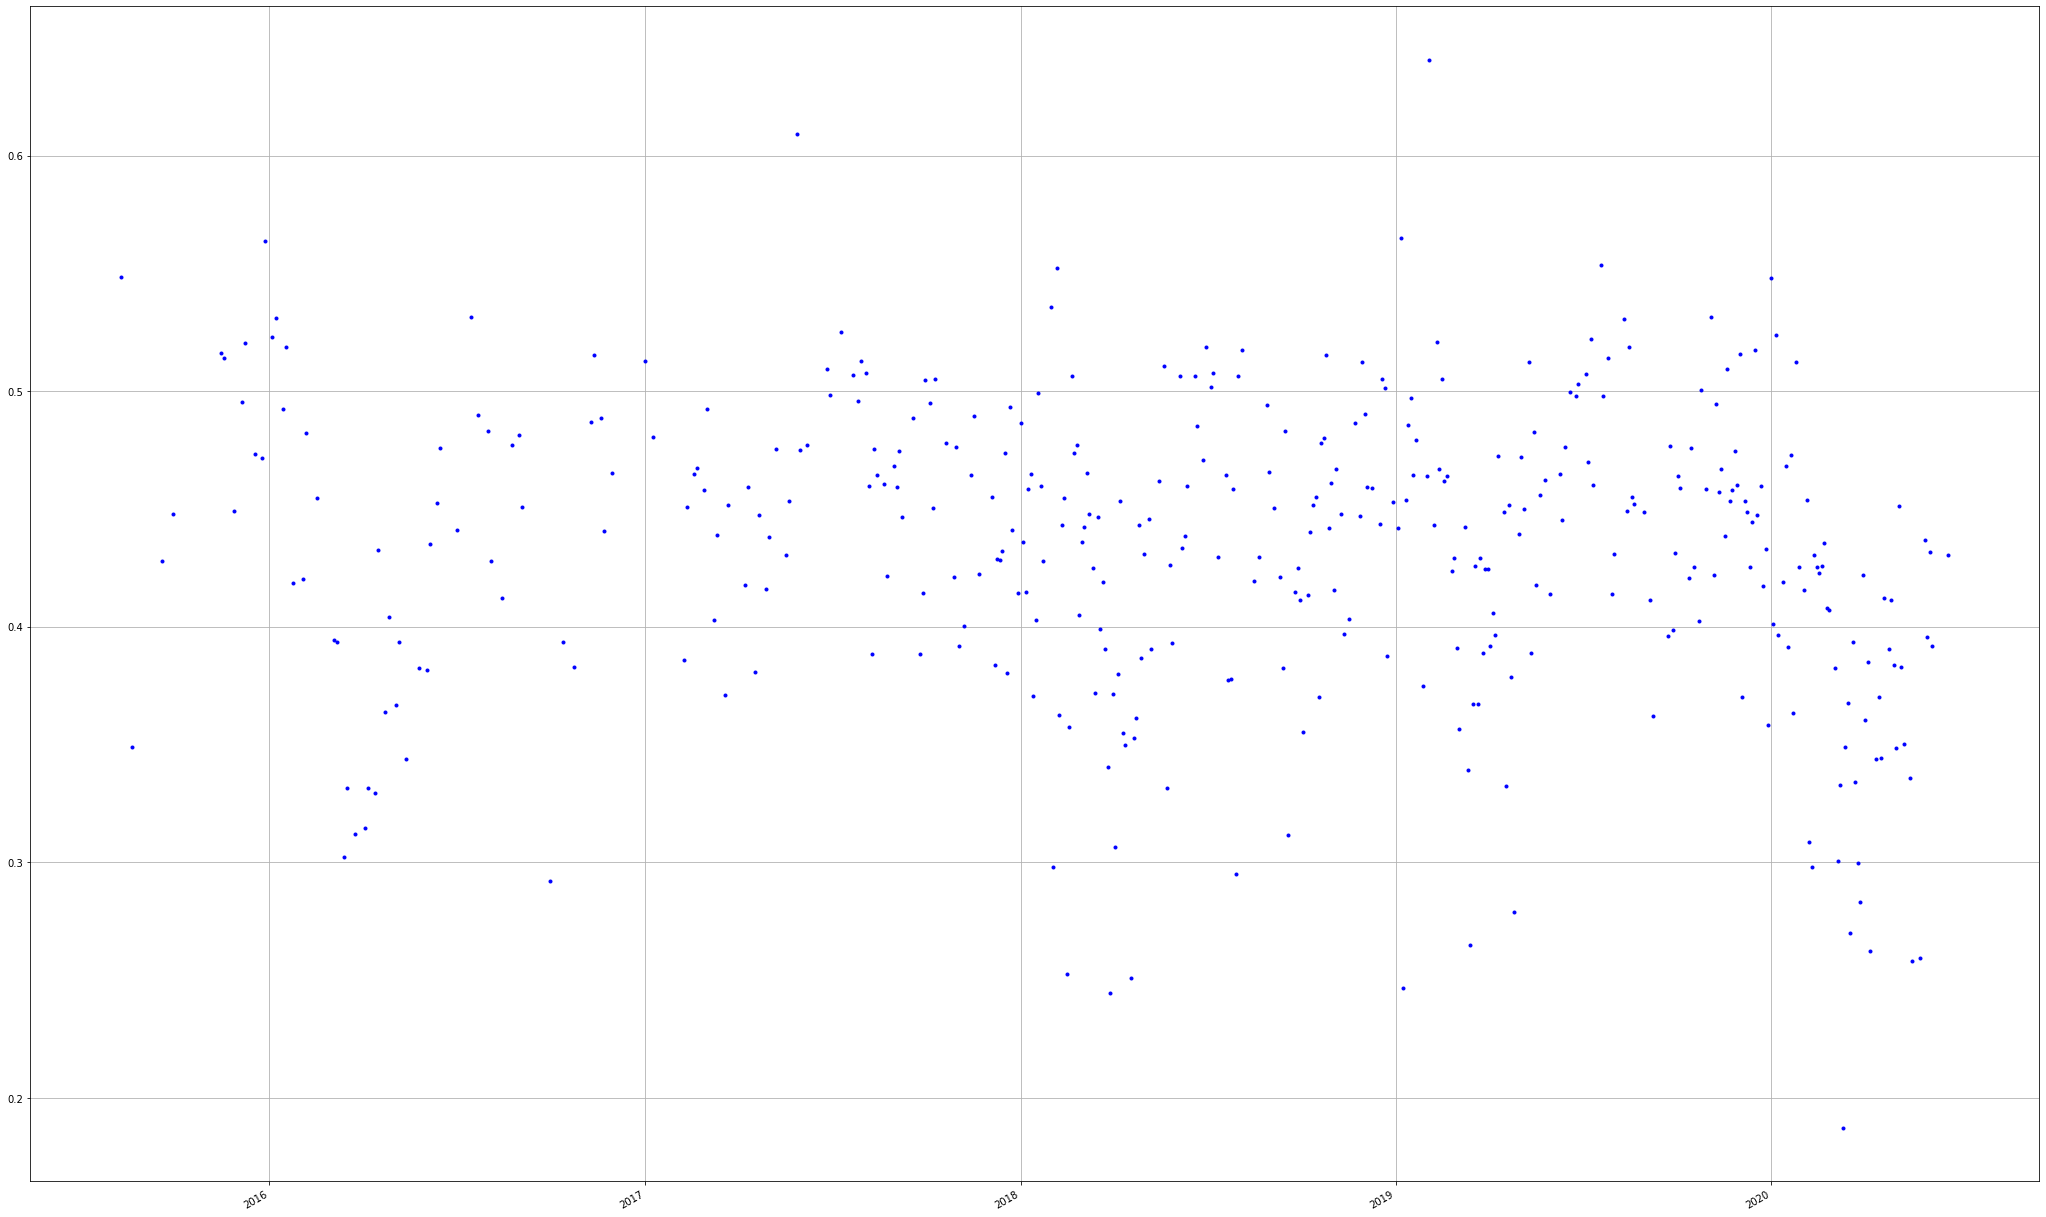

In [10]:
# PLOT OF NDVI VALUES (not part of the processing)
plt.rcParams["figure.figsize"] = [36, 24]

fig, ax = plt.subplots()
ax.xaxis_date()
fig.autofmt_xdate()
ax.grid()
ax.plot(dates, values, 'b.')

In [11]:
from scipy.optimize import curve_fit

In [12]:
def func(x,a,b,c,d):
    return a*np.sin(b*x + c) + d

In [13]:
popt, pcov = curve_fit(func, dates, values, p0=[0.5,0.02,0,0.2])
print(popt)

[-3.23423169e-02  1.74522357e-02  4.57884392e+01  4.36162601e-01]


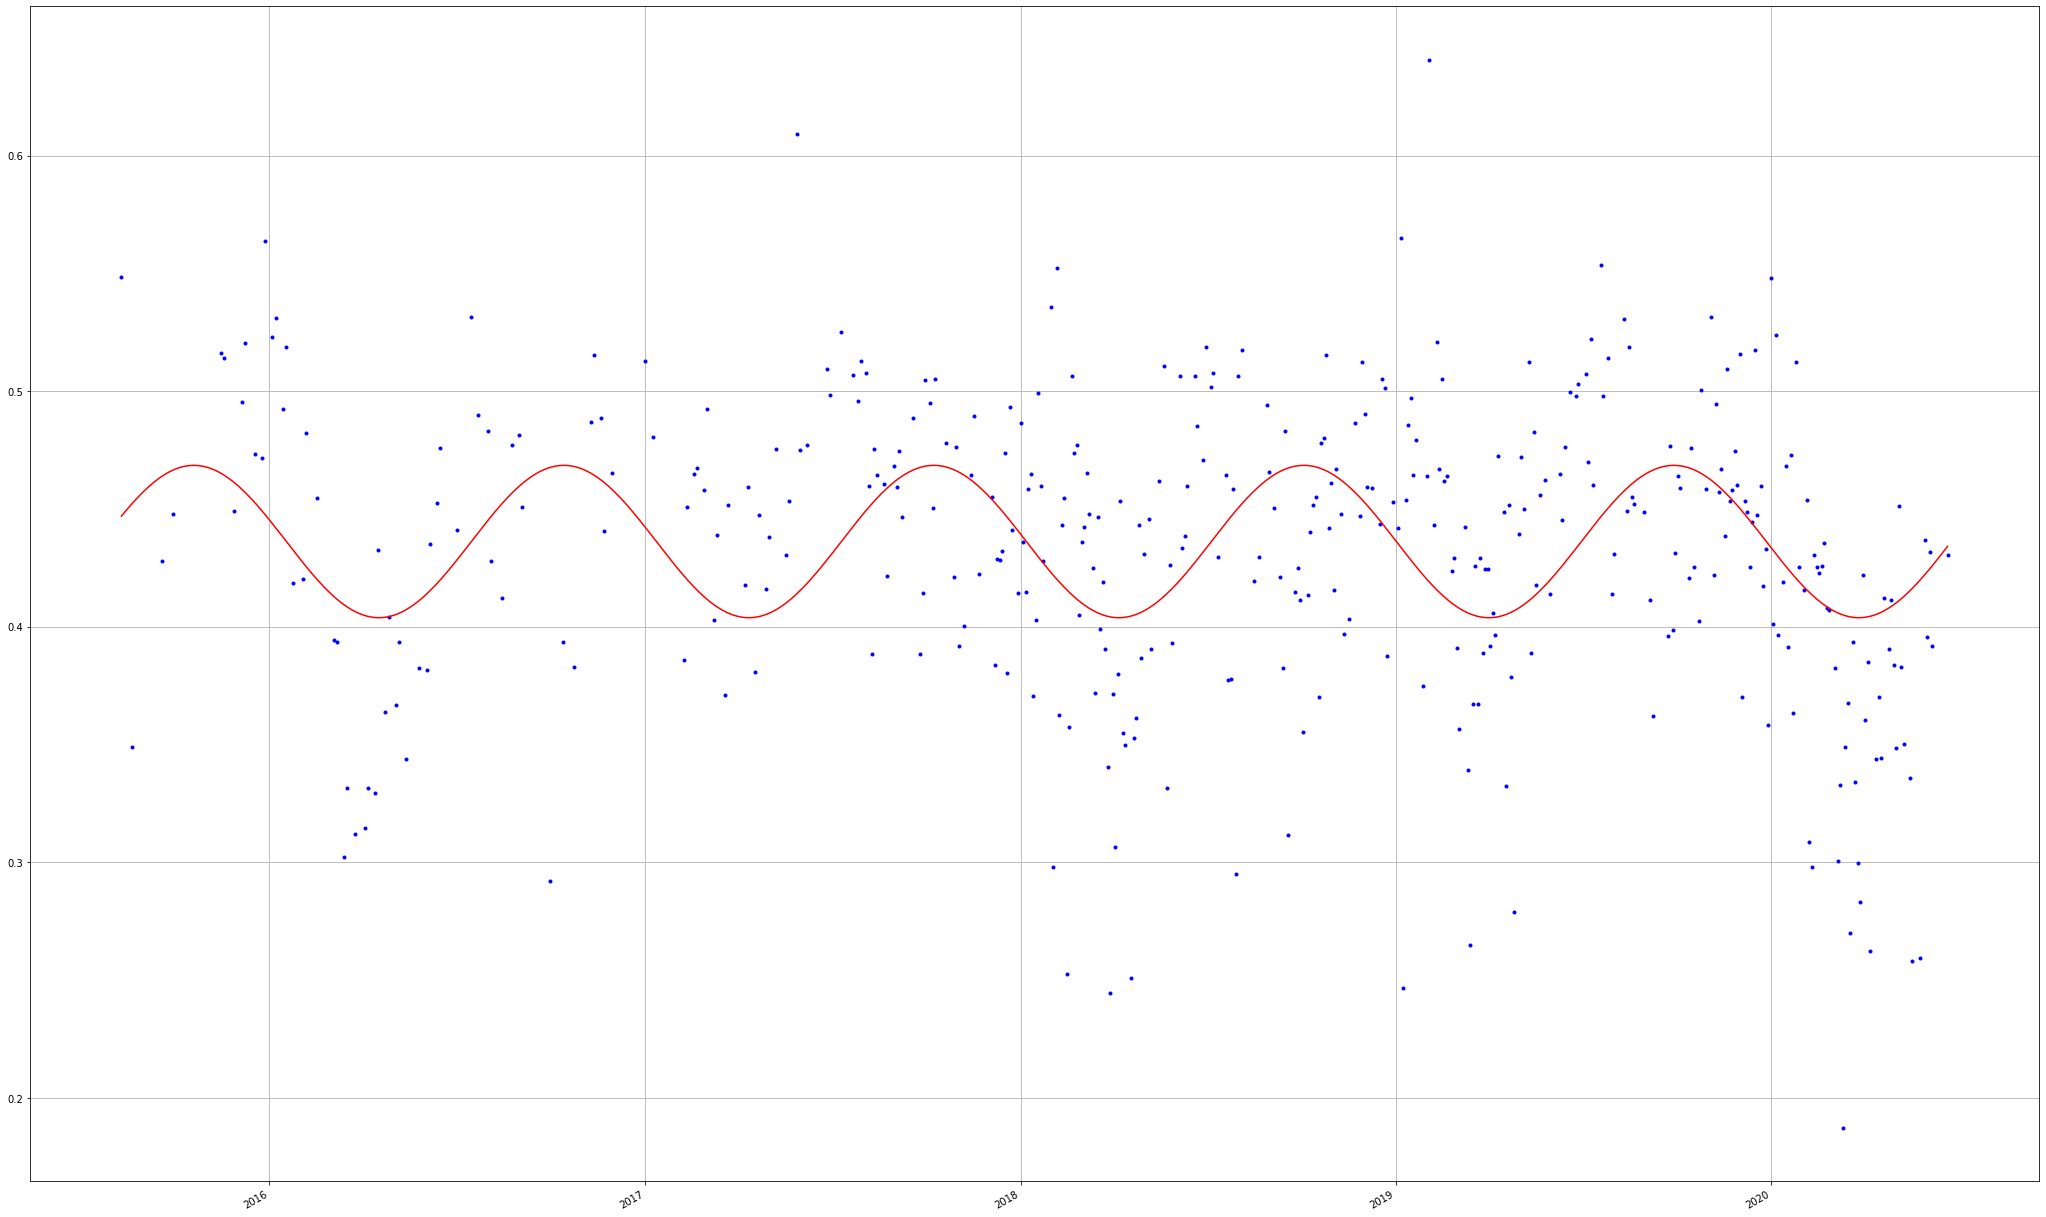

In [14]:
# FITTING A SINE TO THE NDVI (not part of the processing)
plt.rcParams["figure.figsize"] = [36, 24]

fig, ax = plt.subplots()
ax.xaxis_date()
fig.autofmt_xdate()
ax.grid()
x = np.linspace(min(dates), max(dates), 1000)
ax.plot(dates, values, 'b.', x, func(x, *popt), 'r-')

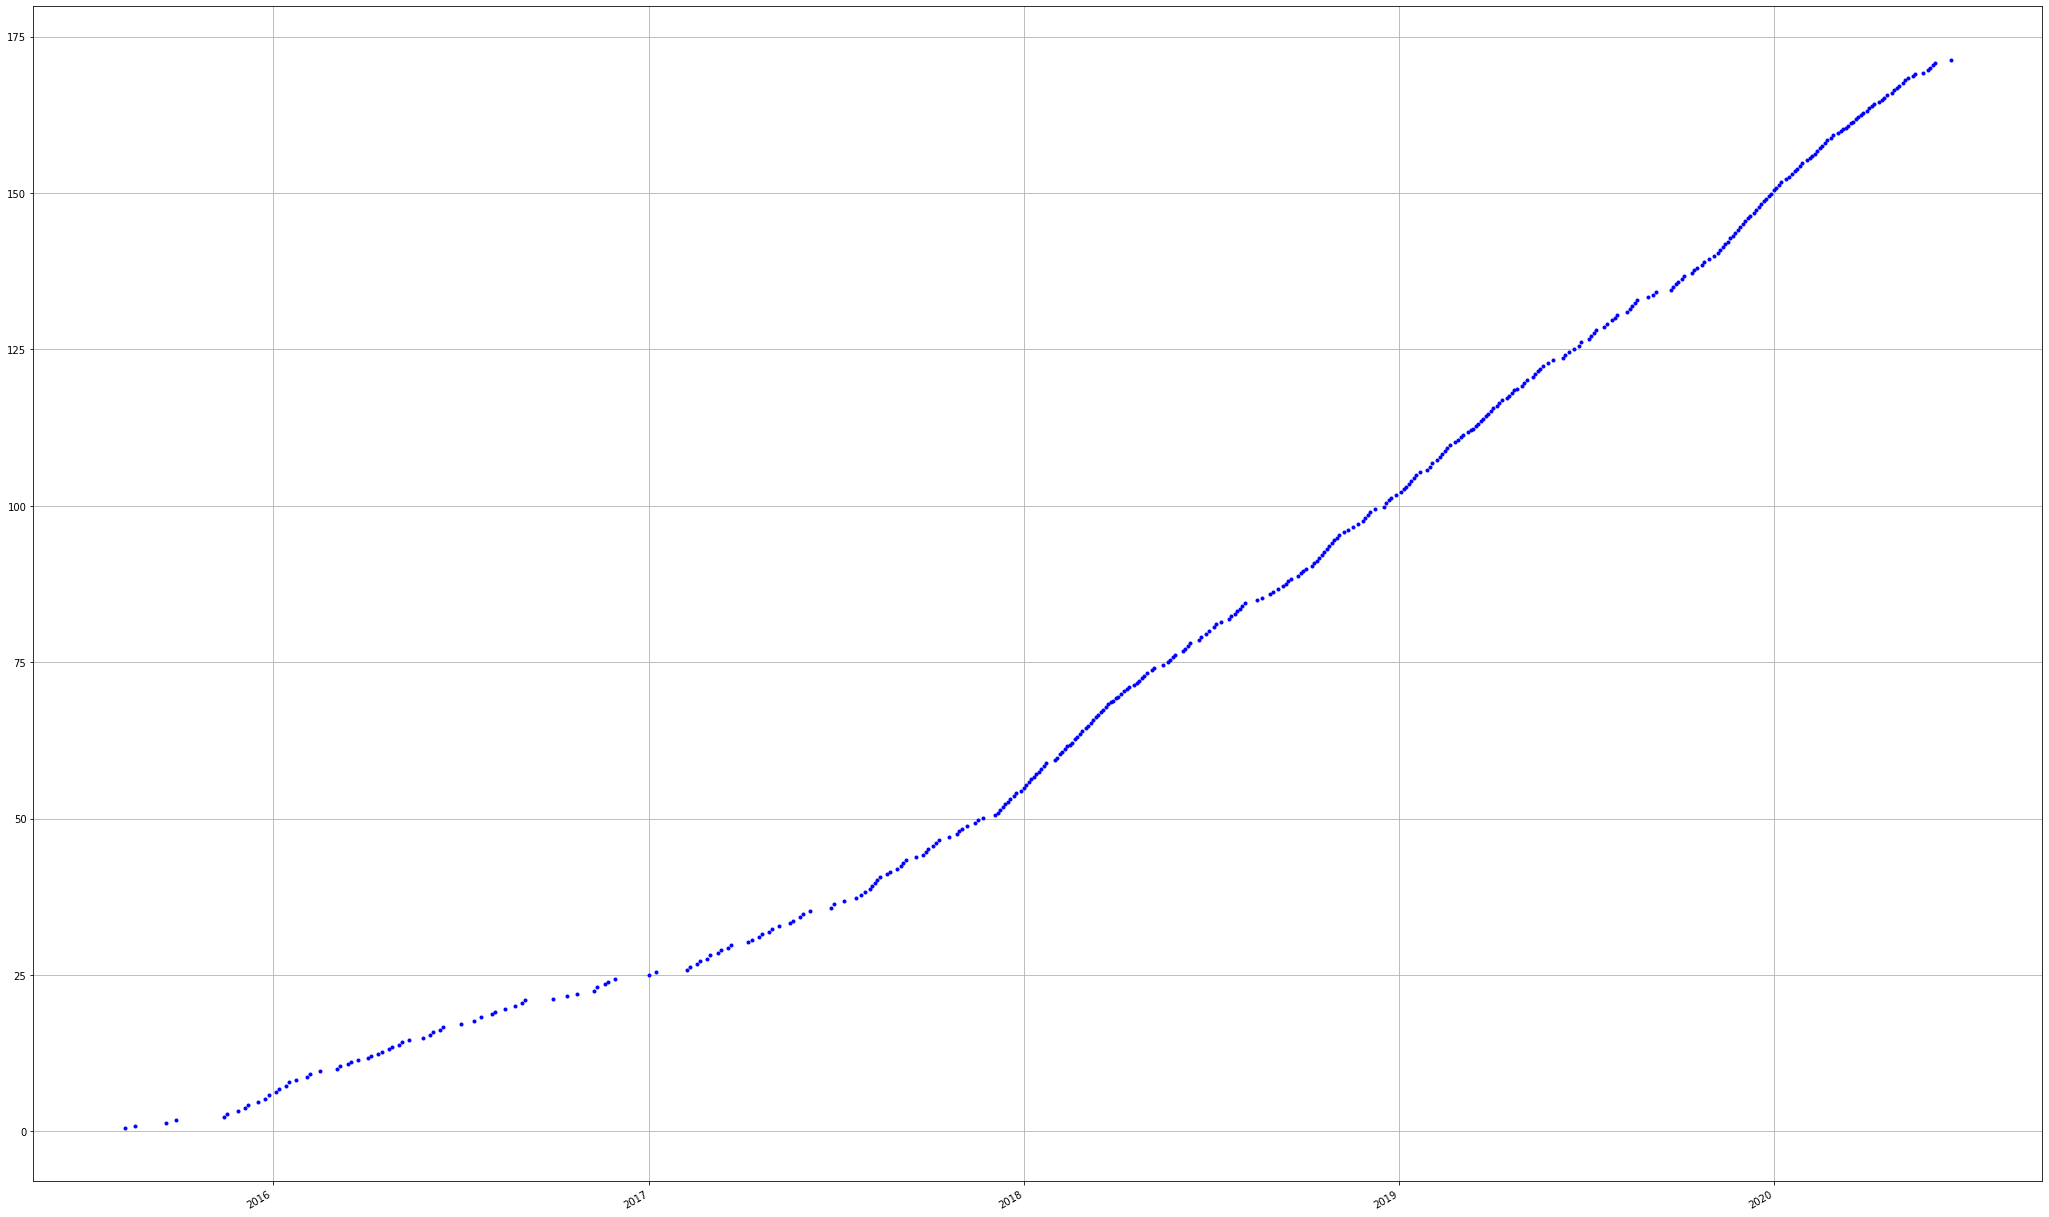

In [15]:
# CUMULATIVE NDVI VISUALIZATION (not part of the processing)
plt.rcParams["figure.figsize"] = [36, 24]

fig, ax = plt.subplots()
ax.xaxis_date()
fig.autofmt_xdate()
ax.grid()
d = dates[::-1]
v = values[::-1]
cvalues = v[1:]/np.diff(v)
ax.plot(dates, np.cumsum(values), 'b.')

<BarContainer object of 58 artists>

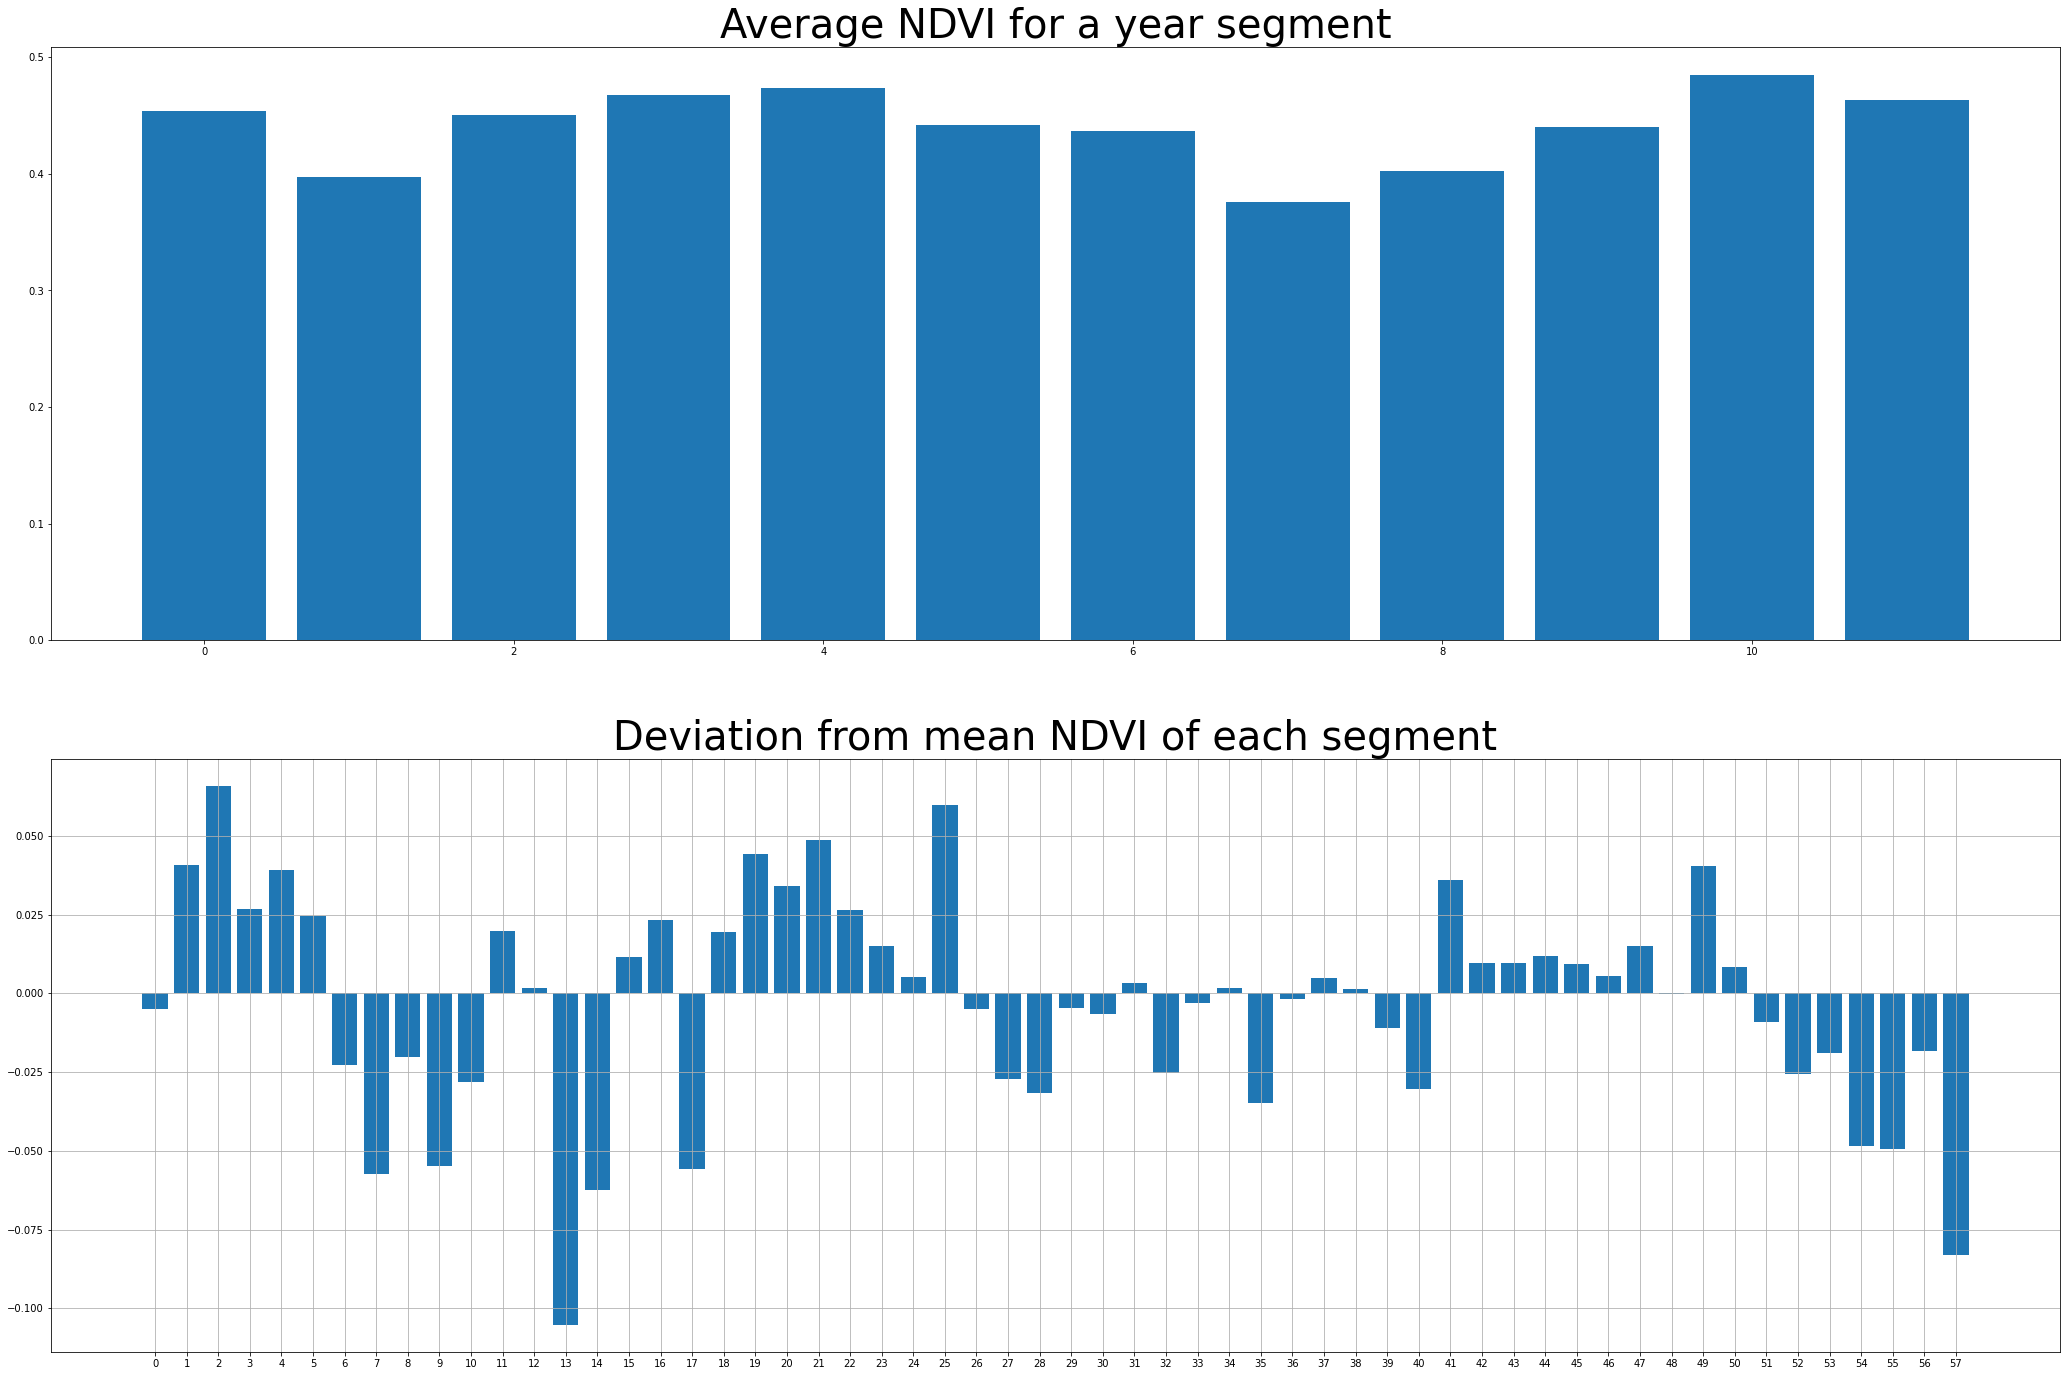

In [16]:
n_year_segments = 12

timerange_length = 365.25/n_year_segments
timerange_value = 0
timerange_n = 0
timerange_start = None
vals = []

for i,aq in enumerate(dates):
    if timerange_start is None:
        timerange_value = values[i]
        timerange_n = 1
        timerange_start = aq
    elif aq - timerange_start <= timerange_length:
        timerange_value += values[i]
        timerange_n += 1
    else:
        vals.append(timerange_value/timerange_n)
        timerange_start += timerange_length
        timerange_value = values[i]
        timerange_n = 1

fig, axs = plt.subplots(2, 1)

avg_vals = []

for i in range(n_year_segments):
    v = vals[i:-n_year_segments:n_year_segments]
    avg_vals.append(sum(v)/len(v))

axs[0].set_title("Average NDVI for a year segment", size=40)
axs[0].bar(np.arange(n_year_segments), avg_vals)

diffs = []

for i,v in enumerate(vals):
    diffs.append(v-avg_vals[i%n_year_segments])

plt.xticks(np.arange(len(vals)), np.arange(len(vals)))
axs[1].grid()
axs[1].set_title("Deviation from mean NDVI of each segment", size=40)
axs[1].bar(np.arange(len(vals)), diffs)

In [17]:
def index_to_date(index, start_date, timerange_length):
    return mdates.num2date(start_date + timerange_length * index).replace(tzinfo=None)

In [18]:
def get_max_segment(index, n_year_segments, diffs):
    start_index = index % n_year_segments
    maxim_index = start_index
    for i in range(start_index, len(diffs), n_year_segments):
        if diffs[i] >= diffs[maxim_index]:
            maxim_index = i
    return maxim_index

In [19]:
def get_recent_below_average_period(diffs):
    # Returns ordered list of segments with below average NDVI
    # The period must start at the most recent segment, otherwise an empty list is returned
    below_average_period = []
    for i in range(len(diffs)-1,0,-1):
        if diffs[i] < 0:
            below_average_period.append(i)
        else:
            return sorted(below_average_period, key=lambda x: diffs[x])

In [20]:
indices = get_recent_below_average_period(diffs)

start_date = index_to_date(indices[0], dates[0], timerange_length)
end_date = index_to_date(indices[0]+1, dates[0], timerange_length)

print("Segment with most below average NDVI")
print(start_date, end_date)

Segment with most below average NDVI
2020-05-09 22:30:00 2020-06-09 09:00:00


In [21]:
# Find best available date in the segment with the lowest NDVI

cloud_data = fis_data[0]['C1'][::-1]
cloud_dates = [datetime.fromisoformat(d['date']) for d in cloud_data]
cloud_values = [d['basicStats']['mean'] for d in cloud_data]

n_pixels = (bbox_dimension/resolution)**2
data_mask_data = fis_data[0]['C2'][::-1]
data_mask_values = [(sum(i["count"] for i in d['histogram']['bins']))/(n_pixels) for d in data_mask_data]

def dates_bisection(start_date, cloud_dates):
    l = 0
    u = len(cloud_dates) - 1
    while True:
        if l == u or l + 1 == u:
            break
        ind = (l+u)//2
        if cloud_dates[ind] > start_date:
            u = ind
        elif cloud_dates[ind] < start_date:
            l = ind
        else:
            break
    return u

u = dates_bisection(start_date, cloud_dates)

def find_best_date(start_ind, end_date, cloud_dates, cloud_values, data_mask_values):
    print("Date | Cloud coverage | Coverage")
    min_coverage = 9999
    best_ind = start_ind
    for i in range(start_ind, len(cloud_dates)):
        if cloud_dates[i] < end_date:
            print(cloud_dates[i], cloud_values[i], data_mask_values[i])
            if cloud_values[i]**2 *(1-data_mask_values[i]) < min_coverage:
                min_coverage = cloud_values[i]**2 *(1-data_mask_values[i])
                best_ind = i
        else:
            return best_ind
            
best_ind = find_best_date(u, end_date, cloud_dates, cloud_values, data_mask_values)
        
print("\nBest Date:")
print(cloud_dates[best_ind])

Date | Cloud coverage | Coverage
2020-05-10 00:00:00 0.4676098242570994 0.07379466666666666
2020-05-12 00:00:00 0.11124938364366439 0.018928444444444446
2020-05-15 00:00:00 0.9715101582248621 0.3797688888888889
2020-05-17 00:00:00 0.7139439149053616 0.08043333333333333
2020-05-25 00:00:00 0.9229251953851975 0.07165333333333333
2020-05-30 00:00:00 0.5648457385726486 0.6165435555555555
2020-06-01 00:00:00 0.42498247430463176 0.4120933333333333
2020-06-04 00:00:00 0.3699483082706793 0.06431288888888889
2020-06-06 00:00:00 0.6786626151984994 0.35528044444444445

Best Date:
2020-05-12 00:00:00


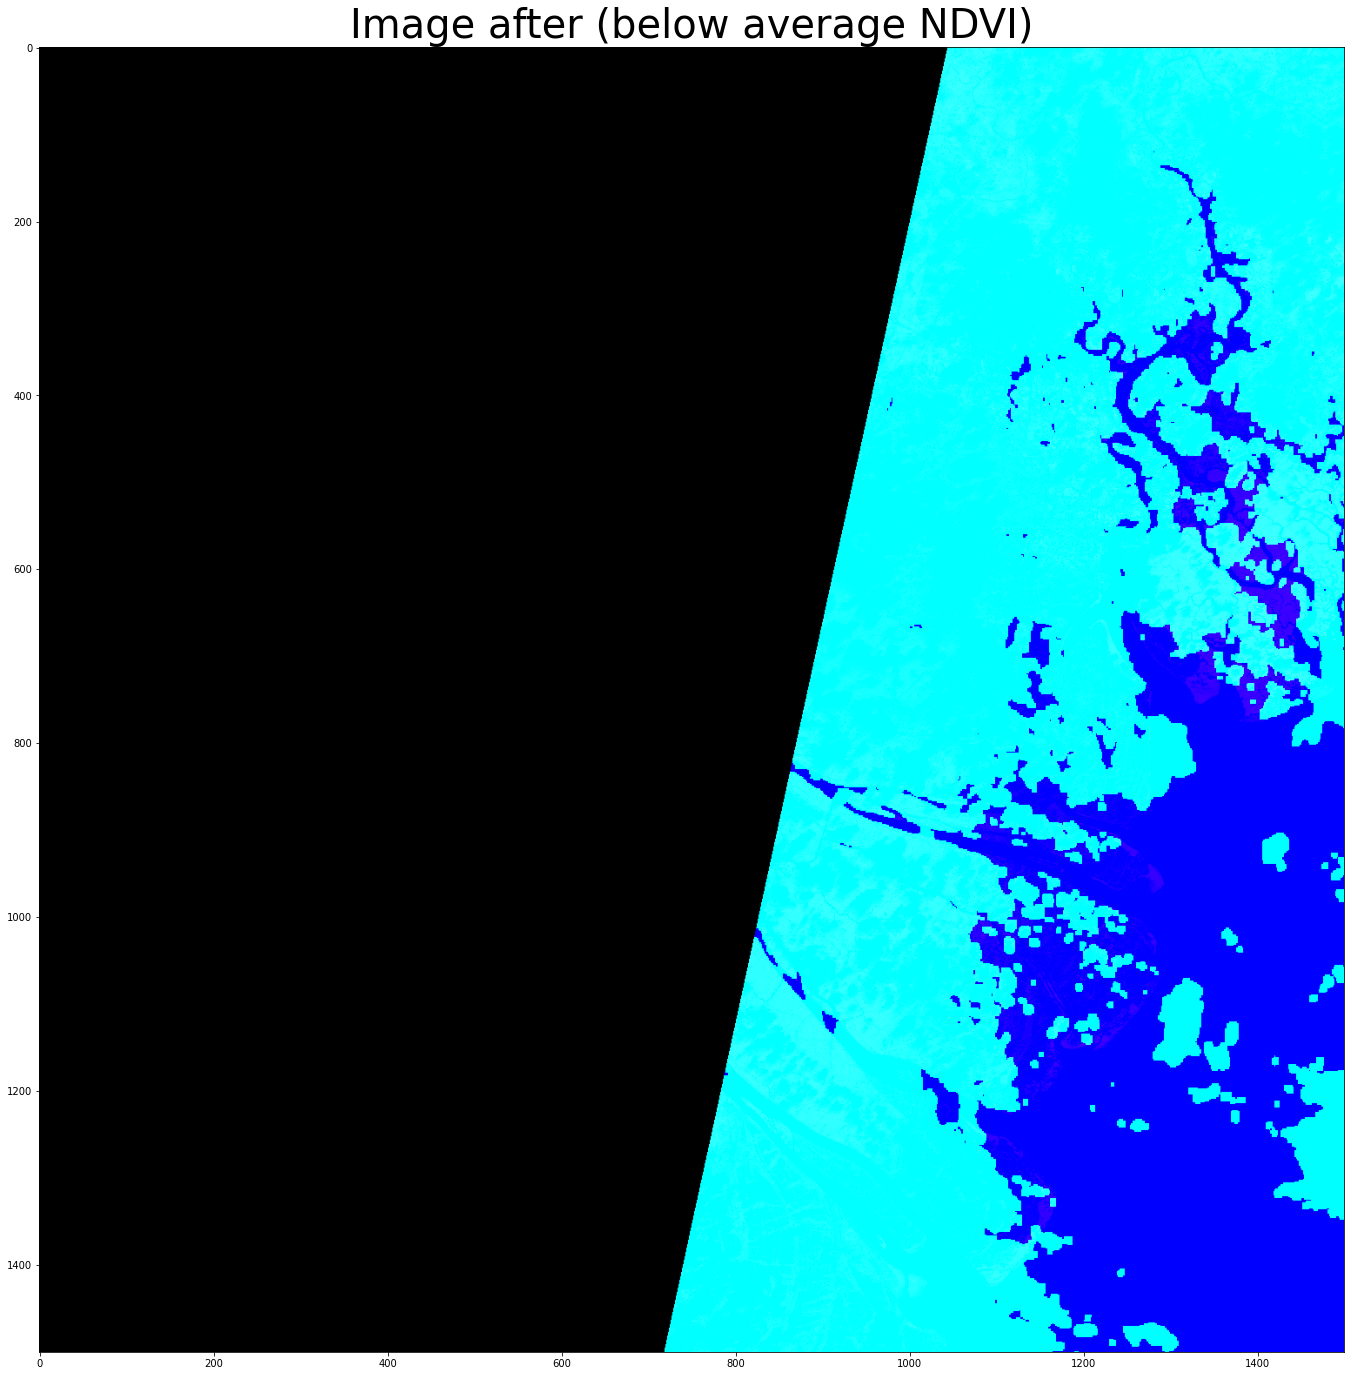

In [22]:
width = height = int(bbox_dimension / resolution)
image_after = get_image(bbox, start_of_day(cloud_dates[best_ind]), end_of_day(cloud_dates[best_ind]), width, height, ndvi_evalscript, data_collection, "https://services.sentinel-hub.com/api/v1/process", config)

plt.title("Image after (below average NDVI)", size=40)
plt.imshow(image_after)

In [23]:
def get_closest_good_segment(ind, n_year_segments, diffs):
    # Gets closest segment with average or above average NDVI in preceding years
    best_val = -9999
    best_ind = None
    for i in range(ind, 0, -n_year_segments):
        if diffs[i] > 0:
            return i
        if diffs[i] > best_val:
            best_val = diffs[i]
            best_ind = i
    return best_ind
            
ind = get_closest_good_segment(indices[0], n_year_segments, diffs)

start_date = index_to_date(ind, dates[0], timerange_length)
end_date = index_to_date(ind+1, dates[0], timerange_length)
index_date = dates_bisection(start_date, cloud_dates)

best_ind = find_best_date(index_date, end_date, cloud_dates, cloud_values, data_mask_values)

print("\nBest Date:")
print(cloud_dates[best_ind])

Date | Cloud coverage | Coverage
2019-05-11 00:00:00 0.49306905771133536 0.5508951111111111
2019-05-13 00:00:00 0.6682449919874092 0.37968044444444443
2019-05-16 00:00:00 0.44991889616656844 0.10822888888888889
2019-05-18 00:00:00 0.6063584268780847 0.3963244444444444
2019-05-21 00:00:00 0.48329123032495686 0.6930093333333334
2019-05-26 00:00:00 0.5548499598382355 0.582644
2019-05-31 00:00:00 0.6134349480857966 0.1940808888888889
2019-06-10 00:00:00 0.8407300420168072 0.06431288888888889

Best Date:
2019-05-21 00:00:00


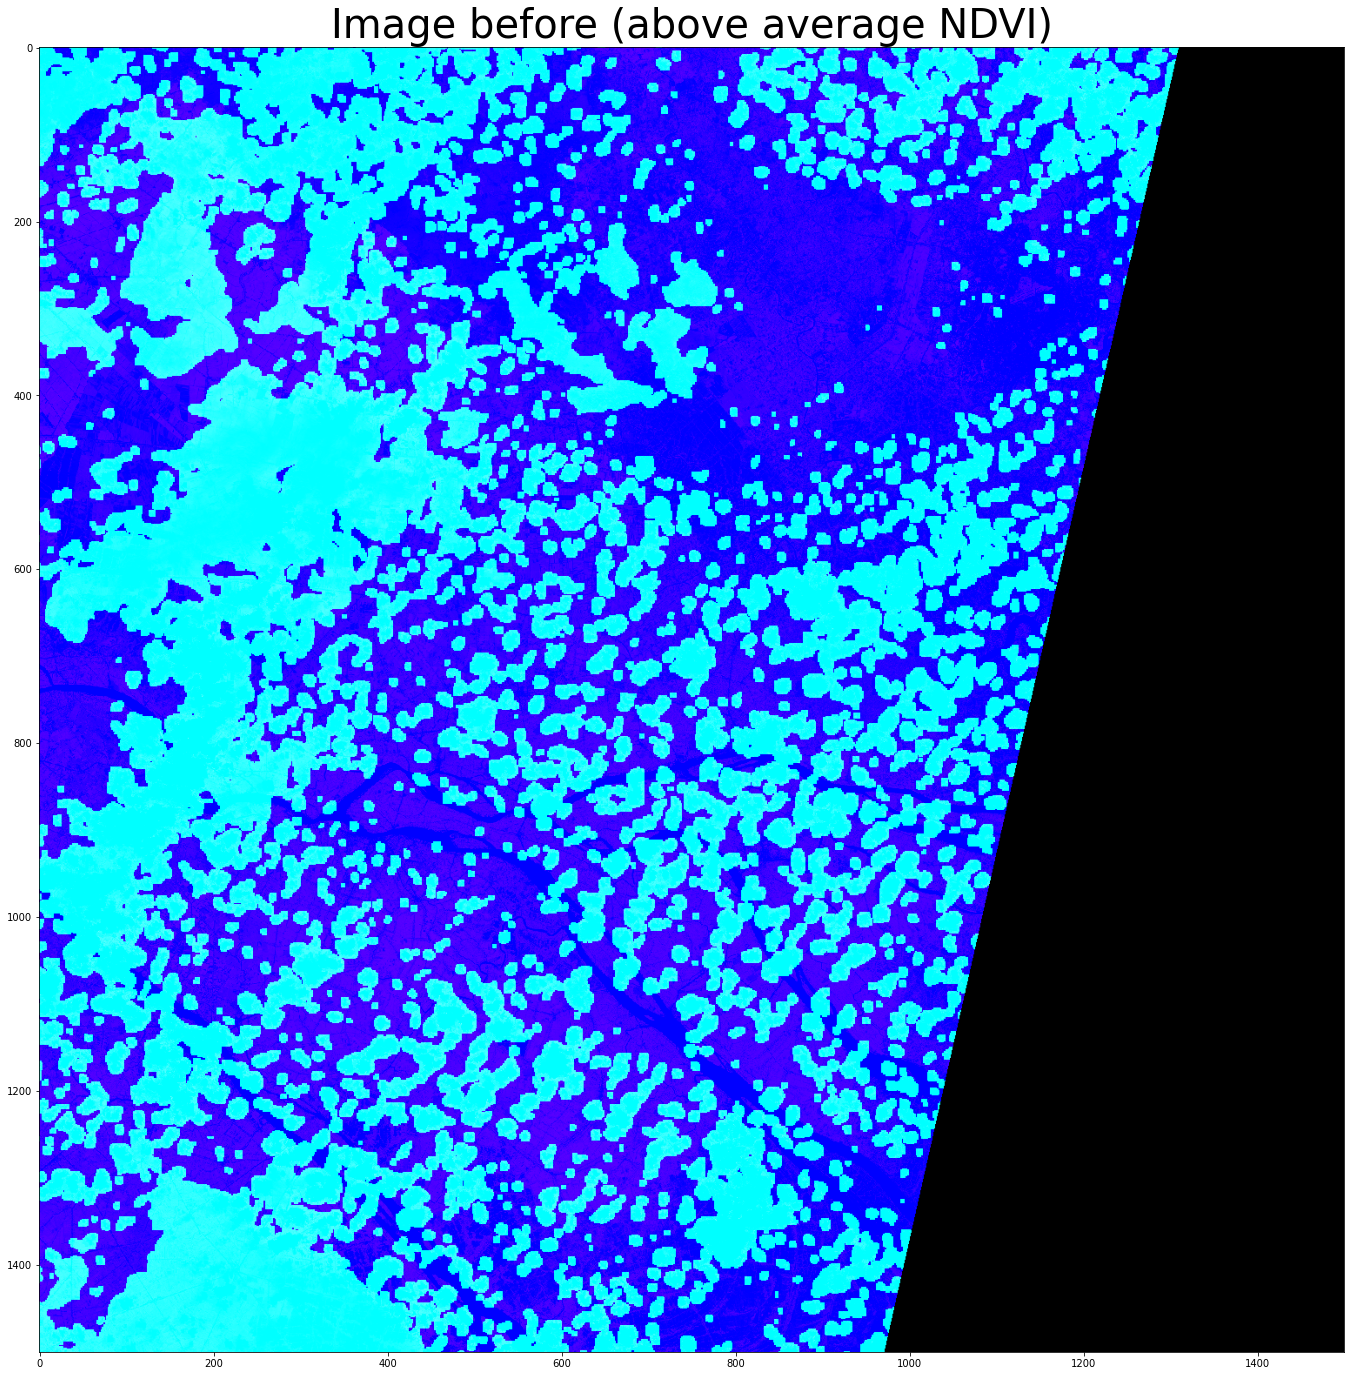

In [24]:
image_before = get_image(bbox, start_of_day(cloud_dates[best_ind]), end_of_day(cloud_dates[best_ind]), width, height, ndvi_evalscript, data_collection, "https://services.sentinel-hub.com/api/v1/process", config)

plt.title("Image before (above average NDVI)", size=40)
plt.imshow(image_before)

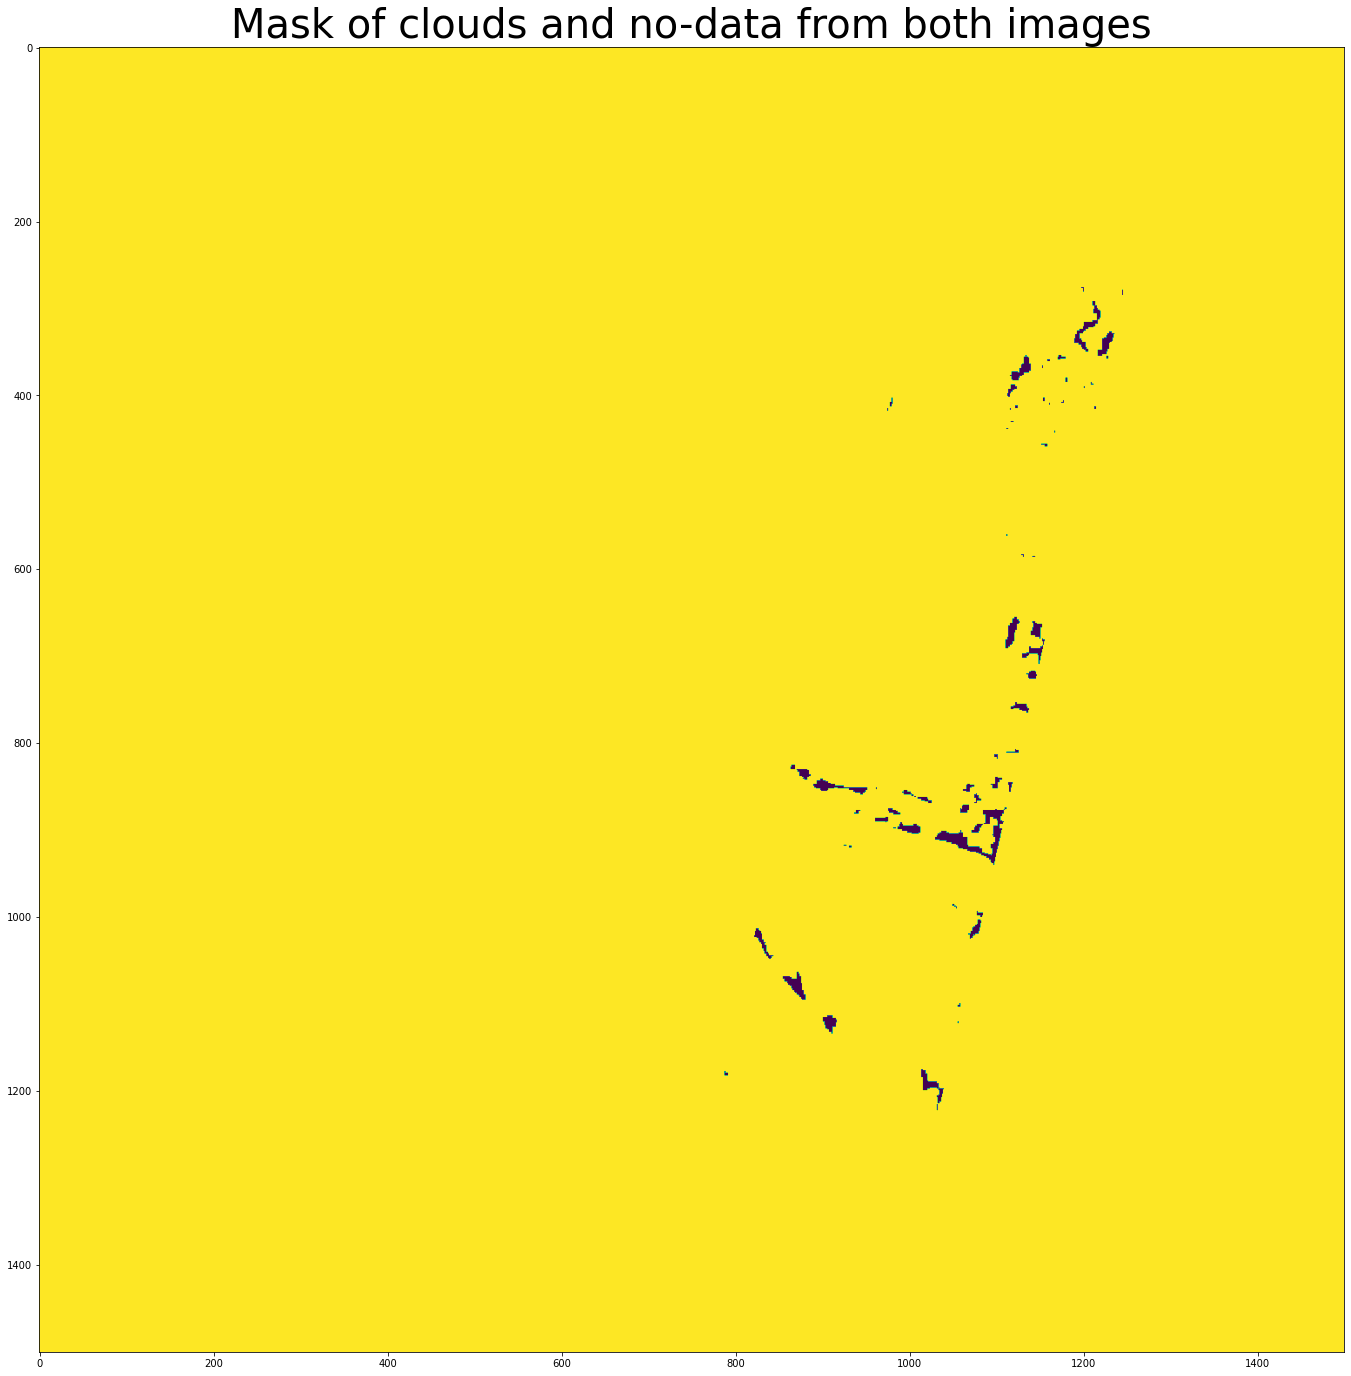

In [25]:
image_before = image_before/255
image_after = image_after/255

ndvi_before = image_before[:,:,0]
clouds_before = image_before[:,:,1]
data_mask_before = image_before[:,:,2]
mask_before = np.logical_or(clouds_before, np.logical_not(data_mask_before))

ndvi_after = image_after[:,:,0]
clouds_after = image_after[:,:,1]
data_mask_after = image_after[:,:,2]
mask_after = np.logical_or(clouds_after, np.logical_not(data_mask_after))

mask = np.logical_or(mask_before, mask_after)
plt.title("Mask of clouds and no-data from both images", size=40)
plt.imshow(mask)

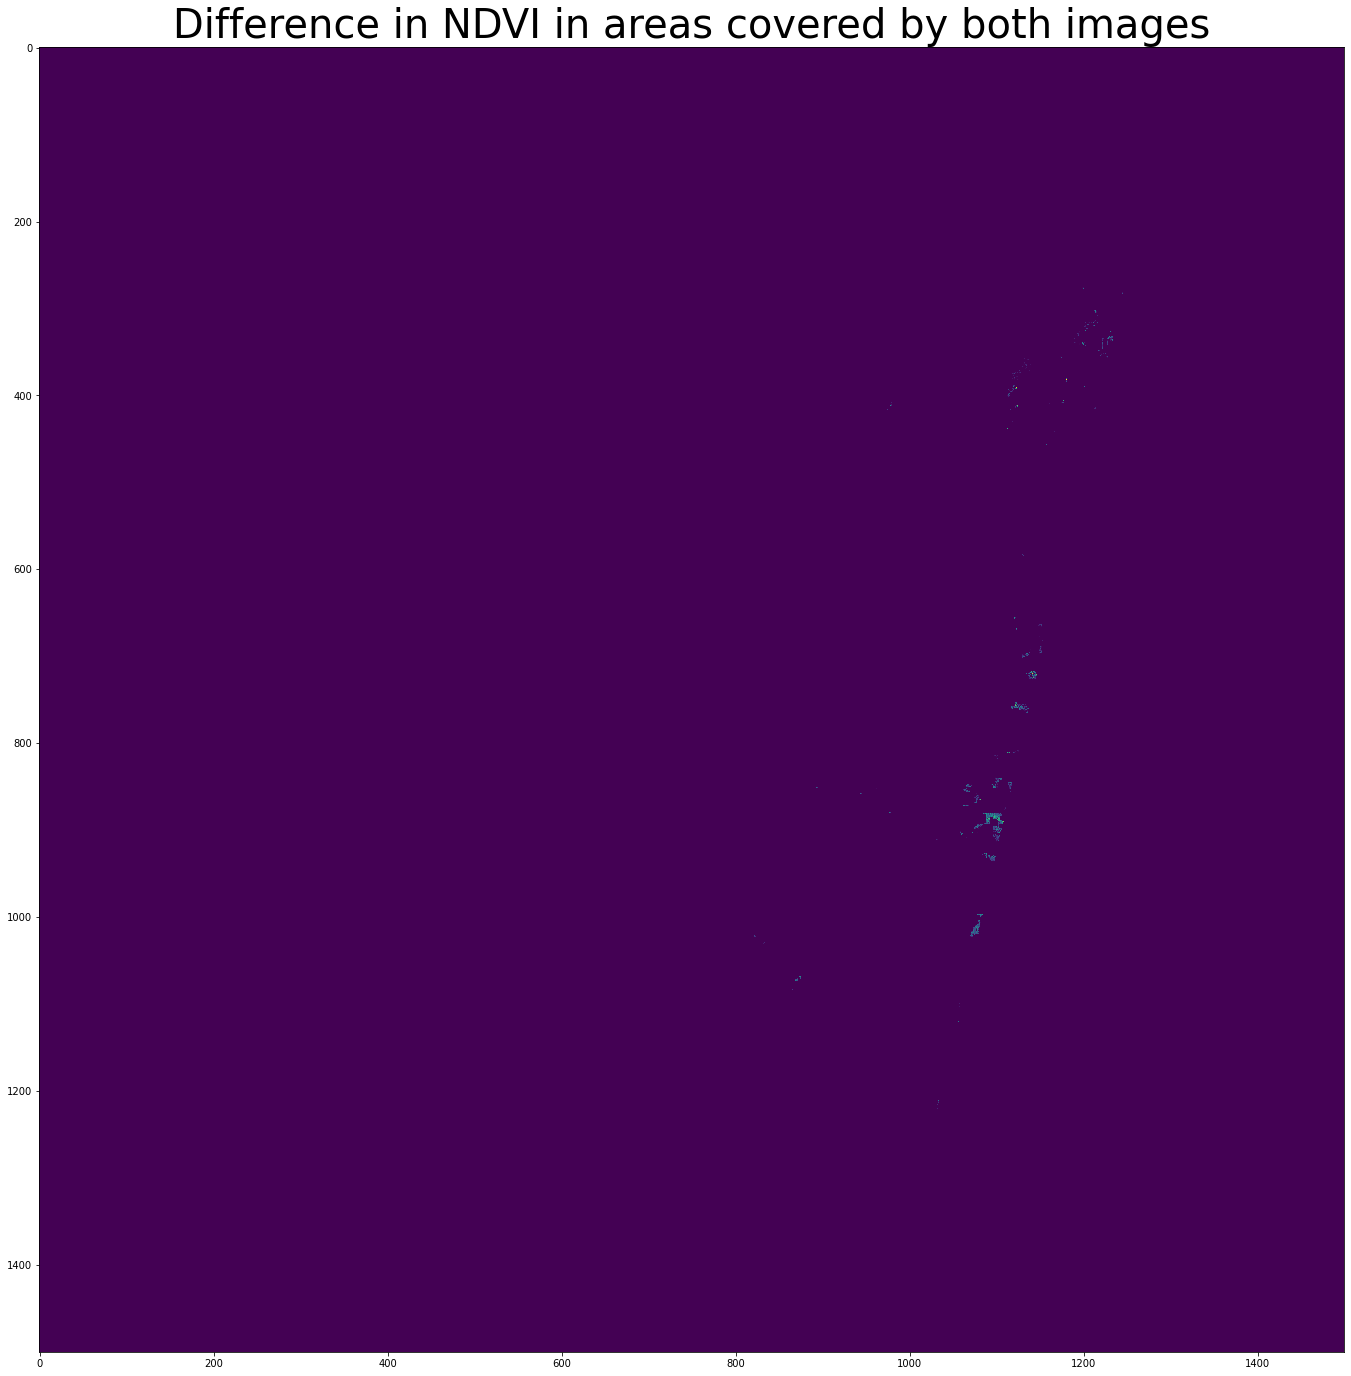

In [26]:
ndvi_before[mask] = 0
ndvi_after[mask] = 0
change = ndvi_before - ndvi_after
change[change <= 0] = 0

plt.title("Difference in NDVI in areas covered by both images", size=40)
plt.imshow(change, interpolation="none")